# Learning Nim with Temporal Difference
This Notebook contains the main code to make an agent learn how to play Nim with Temporal Difference learning. The algorithm used is Q-learning.

## 1 - Initialization
In this part we initialize the variables and function needed.
Under "Variables initialization", the different parameters can be modified.

In [7]:
# import general librairies
from time import sleep
import random as rnd
import matplotlib.pyplot as plt
from IPython.display import clear_output
# personal librairies
from SA import SA
from AgentQ import AgentQ
from Opponent import Opponent

# Variables initialization
##########
# Reinforcement learning
discount = 1 # no discounting (=gamma)
stepSize = 1 # alpha , the learning rate
epsilon = 1 # for the epsilon-greedy policy
opp_epsilon = 0. # fraction of randomness for the opponent of the learning phase
# Nim
board_ini = sorted([5,5,5,5]) # Biggest board for learning Nim (bigger board won't be learned)
runMax = int(3E4) # Number of runs for the learning
##########

# Function initialization
def init_board():
    """
    Return a random board based on board_ini
    """
    for i in range(len(board_ini)):
        board[i] = rnd.randint(0,board_ini[i])
    board.sort()
    
    if board[-1] == 0:
        return init_board()
    return board

## 2 - Reinforcement Learning
This is in this section that the agent will actually learn. "runMax" (above) contains the number of runs for the learning (an output is displayed at the bottom to help keep track of the current run).
Nothing can be modified here.

In [10]:
# Board and agent
board = list(board_ini)
board_end = [0] * len(board_ini)
agent = AgentQ(SA(board), stepSize, discount, epsilon)
oppLearning = Opponent(SA(board), policy="e-optimal", epsilon=opp_epsilon)
oppOptimal = Opponent(SA(board), policy="optimal")

# Learning curves lists
learning_win = []
greedy_win = []
optimalMoves = []
optimalMoves_runNb = []
optMoveFound_Recall = []
optMoveFound_Precision = []
optMoveFound_F = []
optMoveFound_runNb = []

# Actual learning
for run in range(runMax):
    if (run+1) % 1000 == 0:
        clear_output()
        print("run   : {0}/{1}\n".format(run+1, runMax))
    
    board = init_board()
    
    # randomly choose the first player
    agentIsFirst = rnd.randint(0,1)
    if agentIsFirst == False:
        oppLearning.move(board)
        if board == board_end:
            learning_win.append(-1)
            continue
    
    # move until the end of the current game
    while True:
        agent.move(board)
        if board == board_end:
            agent.winUpdate()
            learning_win.append(1)
            break
        
        oppLearning.move(board)
        if board == board_end:
            agent.loseUpdate()
            learning_win.append(-1)
            break
            
        agent.updateQ(board)
    
    ## Test the agent every 100 runs on 100 more runs
    # Here, the agent uses a greedy policy
    if (run+1) % 100 == 0:
        optMovePossible = 0.
        optMoveMade = 0.
        wins = 0.
        for _ in range(100):
            
            ## The agent should always start in a winning position
            # or it will necessarily lose against an optimal opponent
            board = init_board()
            before = 0
            for i in range(len(board)):
                before ^= board[i]
            while before == 0:
                board = init_board()
                before = 0
                for i in range(len(board)):
                    before ^= board[i]
            
            while True:
                before = 0
                for i in range(len(board)):
                    before ^= board[i]
                if before != 0:
                    optMovePossible += 1
                    
                agent.greedyMove(board)
               
                after = 0
                for i in range(len(board)):
                    after ^= board[i]
                if after == 0:
                    optMoveMade += 1
                
                if board == board_end:
                    wins += 1.
                    break
                
                oppOptimal.move(board)
                if board == board_end:
                    wins += 0.
                    break
        
        greedy_win.append(wins)
        optimalMoves.append(optMoveMade/optMovePossible*100)
        optimalMoves_runNb.append(run)
        
        ## Compute current F-Score
        # For each possible actions see if it's optimal and check if the agent
        # considers it as optimal
        optMove_P = 0. # Positives (optimal moves)
        optMove_TP = 0. # True-positives (optimal moves seen as optimal)
        optMove_FP = 0. # False-positives (non-optimal moves seen as optimal)
        for s in agent.states:
            board = list(agent.states[s])
            for heap in range(len(board)):
                for action in range(1,1+board[heap]):
                    temp_board = list(board)
                    temp_board[heap] -= action
                              
                    nimSum = 0
                    for i in range(len(temp_board)):
                        nimSum ^= temp_board[i]
                    
                    
                    a = agent.actions.index([heap,action])
                    if nimSum == 0:
                        optMove_P += 1.
                        if agent.Q[s][a] >= 0.9:
                            optMove_TP += 1.
                    elif agent.Q[s][a] >= 0.9:
                        optMove_FP += 1.
        
        optMoveFound_Recall.append(optMove_TP/optMove_P)
        if optMove_TP+optMove_FP == 0:
            optMoveFound_Precision.append(0.)
        else:
            optMoveFound_Precision.append(optMove_TP/(optMove_TP+optMove_FP))
        if optMoveFound_Precision[-1]+optMoveFound_Recall[-1] == 0:
            optMoveFound_F.append(0.)
        else:
            optMoveFound_F.append(2*optMoveFound_Precision[-1]*optMoveFound_Recall[-1] / \
                              (optMoveFound_Precision[-1]+optMoveFound_Recall[-1]))
        optMoveFound_runNb.append(run)

## 3 - Learning curves
In this section we plot the different curves used to evaluate the learning of the agent.
Here again, nothing can be modified.

### 3.1 Learning curve
We plot here the basic learning curve, that is the reward that the agent is able to get through the learning runs.

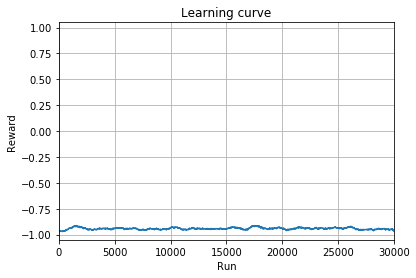

In [11]:
# Window averaging of the learning curve
half_window = 500
learning_win_ave = []

for i in range(len(learning_win)):
    startIndex = i - half_window
    if startIndex < 0:
        startIndex = 0
        
    endIndex = i + half_window + 1
    if endIndex > len(learning_win):
        endIndex = len(learning_win)
    
    learning_win_ave.append(float(sum(learning_win[startIndex:endIndex])) / (len(learning_win[startIndex:endIndex])))
# Learning curve
plt.plot(learning_win_ave)
plt.title("Learning curve")
plt.xlabel("Run"); plt.ylabel("Reward")
plt.axis([0, runMax, -1.05, 1.05]); plt.grid(True)
plt.show()

However, the previous learning curve is actually not really helpful to assess the quality of the agent. Indeed, depending on the set of parameters, the exploration and optimality of the opponent might cause the agent to lose most of the time, even though it learns. That is why we will introduce the few next measures.

### 3.2 - Winning rate
The first way of estimating the agent is to

## 4 - Test of the agent after learning

In [4]:
trials = 2000
wins = 0
winStart = 0
optMove = 0
optDone = 0
for i in range(trials):
    board = init_board()
        
    agentIsFirst = rnd.randint(0,1)
    if agentIsFirst == False:
        oppOptimal.move(board)
        if board == board_end:
            continue
    
    before = 0
    for i in range(len(board)):
        before ^= board[i]
    if before != 0:
        winStart += 1
    while True:
        before = 0
        for i in range(len(board)):
            before ^= board[i]
        if before != 0:
            optMove += 1
            
        agent.greedyMove(board)
       
        after = 0
        for i in range(len(board)):
            after ^= board[i]
        if after == 0:
            optDone += 1
        
        if board == board_end:
            wins += 1
            break
        
        oppOptimal.move(board)
        if board == board_end:
            break

print "Win rate = {}/{} = {:.2f}%\n\nOptimal moves rate = {}/{} = {:.2f}%\n".format(wins, winStart, float(wins)/float(winStart)*100, \
              optDone, optMove, float(optDone)/float(optMove)*100)

optMove_P = 0.
optMove_TP = 0.
optMove_FP = 0.
for s in agent.states:
    board = list(agent.states[s])
    for heap in range(len(board)):
        for action in range(1,1+board[heap]):
            temp_board = list(board)
            temp_board[heap] -= action
                      
            nimSum = 0
            for i in range(len(temp_board)):
                nimSum ^= temp_board[i]
            
            
            a = agent.actions.index([heap,action])
            if nimSum == 0:
                optMove_P += 1.
                if agent.Q[s][a] >= 0.9:
                    optMove_TP += 1.
            elif agent.Q[s][a] >= 0.9:
                optMove_FP += 1.

optMoveFound_Recall = optMove_TP/optMove_P
if optMove_TP+optMove_FP == 0.:
    optMoveFound_Precision = 0.
else:
    optMoveFound_Precision = optMove_TP/(optMove_TP+optMove_FP)
if optMoveFound_Precision+optMoveFound_Recall == 0:
    optMoveFound_F = 0.
else:
    optMoveFound_F = 2*optMoveFound_Precision*optMoveFound_Recall / \
                      (optMoveFound_Precision+optMoveFound_Recall)
                
print "Recall = {:.3f}".format(optMoveFound_Recall)
print "Precision = {:.3f}".format(optMoveFound_Precision)
print "F-measure = {:.3f}".format(optMoveFound_F)

Win rate = 982/982 = 100.00%

Optimal moves rate = 2566/2566 = 100.00%

Recall = 1.000
Precision = 1.000
F-measure = 1.000


## 5 - Play against the agent

In [5]:
clear_output()
wantToPlay = True

while wantToPlay:
    print "Nim - New game\n"
    
    print "Let's start by defining our game:"
    print "There are {} heaps, but some of them might be empty.".format(len(board_ini))
    
    board = []
    for x in range(len(board_ini)):
        num = raw_input("Enter number of matches on heap {}: (must be between 0 and {})\n".format(x+1, board_ini[x]))
        num = int(num)
        while num < 0 or num > 5:
            clear_output()
            print "Wrong number of matches!"
            num = raw_input("Enter number of matches on heap {}: (must be between 0 and {})\n".format(x+1, board_ini[x]))
            num=int(num)
        board.append(num)
    while len(board) < len(board_ini):
        board.append(0)
    
    if board == board_end:
        clear_output()
        print "The board cannot be empty! Let's restart..."
        sleep(1.3)
        continue
    
    clear_output()
    print "Note that the board will be sorted after each move."
    print "Current board: {}\n".format(board)
    board.sort()
    print "Sorted board: {}\n".format(board)
    
    userStart = raw_input("Do you want to start? (y/n)\n")
    
    if userStart.startswith('n') or userStart.startswith('N'):
        print "The agent moves..."
        sleep(1.3)
        agent.greedyMove(board)
        clear_output()
        print "Current board: {}\n".format(board)
    else:
        clear_output()
        print "Current board: {}\n".format(board)
    
    while True:
        userMove = True
        while userMove:
            heap, num = raw_input("Enter heap and number of matches you want to take separated with space ex.(1 2):  ").split()
            heap = int(heap)-1
            num = int(num)
            
            if heap < 0 or heap >= len(board):
                print "Wrong heap! Try again"
                continue
            if num < 1 or num > board[heap]:
                print "Wrong number! Try again"
                continue
            
            board[heap] -= num
            board.sort()
            userMove = False
        
        clear_output()
        if board == board_end:
            print "You won !"
            break
        
        print "Current board: {}\n".format(board)
        print "The agent moves..."
        sleep(1.3)
        agent.greedyMove(board)
        clear_output()
        if board == board_end:
            print "You lost..."
            break
        print "Current board: {}\n".format(board)
        
    wantToPlay = raw_input("Do you want to play again? (y/n)")
    if wantToPlay.startswith('y') or userStart.startswith('Y'):
        wantToPlay = True
    else:
        wantToPlay = False

You won !
Do you want to play again? (y/n)n
